**Libraries:**

In [125]:
# Load libraries
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import sys
import random
import itertools
import matplotlib.pyplot as plt
import time

**Versions used:**

In [257]:
# The libraries versions used here are:
explicitly_loaded = [
    'sklearn',
    'numpy',
    'pandas',
    #'sys', #<- Standard library
    #'random',#<- Standard library
    #'itertools',#<- Standard library
    'matplotlib',
    #'time'#<- Standard library
]

# Show version
for lib in explicitly_loaded:
    if lib in sys.modules:
        module = sys.modules[lib]
        try:
            version = module.__version__
        except AttributeError:
            version = "No version attribute"
        print(f"{lib}=={version}")

print(f"python=={sys.version}")

sklearn==1.4.2
numpy==1.25.2
pandas==1.5.2
matplotlib==3.5.3
python==3.10.12 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 19:01:18) [MSC v.1916 64 bit (AMD64)]


*Dataset used in testing during programming:*

In [4]:
# Load the test data
iris = load_iris()
# Create a pandas dataframe
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [5]:
# extract a matriz from the df
iris_matrix = iris_df.values
iris_matrix

array([[5.1, 3.5, 1.4, 0.2, 0. ],
       [4.9, 3. , 1.4, 0.2, 0. ],
       [4.7, 3.2, 1.3, 0.2, 0. ],
       [4.6, 3.1, 1.5, 0.2, 0. ],
       [5. , 3.6, 1.4, 0.2, 0. ],
       [5.4, 3.9, 1.7, 0.4, 0. ],
       [4.6, 3.4, 1.4, 0.3, 0. ],
       [5. , 3.4, 1.5, 0.2, 0. ],
       [4.4, 2.9, 1.4, 0.2, 0. ],
       [4.9, 3.1, 1.5, 0.1, 0. ],
       [5.4, 3.7, 1.5, 0.2, 0. ],
       [4.8, 3.4, 1.6, 0.2, 0. ],
       [4.8, 3. , 1.4, 0.1, 0. ],
       [4.3, 3. , 1.1, 0.1, 0. ],
       [5.8, 4. , 1.2, 0.2, 0. ],
       [5.7, 4.4, 1.5, 0.4, 0. ],
       [5.4, 3.9, 1.3, 0.4, 0. ],
       [5.1, 3.5, 1.4, 0.3, 0. ],
       [5.7, 3.8, 1.7, 0.3, 0. ],
       [5.1, 3.8, 1.5, 0.3, 0. ],
       [5.4, 3.4, 1.7, 0.2, 0. ],
       [5.1, 3.7, 1.5, 0.4, 0. ],
       [4.6, 3.6, 1. , 0.2, 0. ],
       [5.1, 3.3, 1.7, 0.5, 0. ],
       [4.8, 3.4, 1.9, 0.2, 0. ],
       [5. , 3. , 1.6, 0.2, 0. ],
       [5. , 3.4, 1.6, 0.4, 0. ],
       [5.2, 3.5, 1.5, 0.2, 0. ],
       [5.2, 3.4, 1.4, 0.2, 0. ],
       [4.7, 3

# Common functions

## Function to calculate Euclidean Distance

In [6]:
def calculate_euclidean_distance(np_array1, np_array2):
    """
    Args:
        np_array1 (np.ndarray): 1-dimensional array with n elements 
        np_array2 (np.ndarray): 1-dimensional array with n elements 
    """
    # Calculate: 𝑑 = sqrt((𝑋1 −𝑌1)^2+ (𝑋2 − 𝑌2)^2+ ...  + (𝑋𝑛 − 𝑌𝑛)^2)
    return np.sqrt(np.sum((np_array1 - np_array2) ** 2))

## Function to assign an entry to a cluster

In [7]:
def assign_to_cluster(entry, centroids):
    """
    Args:
        entry (np.ndarray): the entry to be assigned. It is a 1-dimensional array with n elements.
        centroids (List[np.ndarray]): a list containing the centroids of each cluster. Each centroid is a 1-dimensional NumPy array with n elements. 
    """
    # this variable is used to retorn the cluster 
    cluster = -1
    # assign to min_distance the larger float
    min_distance = sys.float_info.max
    num_clusters = len(centroids)
    for i in range(num_clusters):
        # calculate euclidian distance 
        current_distance = calculate_euclidean_distance(entry, centroids[i])
        if current_distance < min_distance:
            min_distance = current_distance
            cluster = i
    # return the cluster to which the entry belongs and the euclidean distance.
    return cluster, min_distance

## Function to assign all entries to clusters (get clusters)

In [8]:
def get_clusters(matrix, centroids):
    """
    Args: 
        matrix (np.ndarray): an mxn matrix obtained from the pandas dataframe.
        centroids (List[np.ndarray]): a list containing the centroids of each cluster. Each centroid is a 1-dimensional NumPy array with n elements. 
    """
    # declare a list of lists, each inner list represents a different cluster
    clusters = [[] for _ in range(len(centroids))]
    # iterate over the rows
    for i in range(matrix.shape[0]):
        # get the cluster to which the entry belongs.
        cluster_assigned, _ = assign_to_cluster(matrix[i, :], centroids)
        clusters[cluster_assigned].append(i)
    return clusters

## Function to initialize centroids with random numbers 

In [9]:
def init_centroids_random(matrix, centroids): 
    """
    Args: 
        matrix (np.ndarray): an mxn matrix obtained from the pandas dataframe.
        centroids (List[np.ndarray]): a list containing the centroids of each cluster. Each centroid is a 1-dimensional NumPy array with n elements. 
    """
    dimensions = matrix.shape[1] # number of columns
    centroids_count = len(centroids)
    # Iterate through column
    for i in range(dimensions):
        # get the range of column values 
        min_value = np.min(matrix[:, i])
        max_value = np.max(matrix[:, i])
        # Iterate through centroids
        for j in range(centroids_count):
            # generate a random number within the range. 
            centroids[j][i] = np.random.uniform(min_value, max_value)
    return centroids

In [10]:
def recalculate_centroids(matrix, clusters):
    """
    Args: 
        matrix (np.ndarray): an mxn matrix obtained from the pandas dataframe.
        clusters (List[List[]]): a list containing lists representing clusters. 
            Each inner list contains the index of each entry that belongs to the cluster.
    """
    #dimentions = matrix.shape[1]
    n_clusters = len(clusters)
    # declare a list that represent centroids
    centroids = [None] * n_clusters
    for i in range(n_clusters):
        if len(clusters[i]) > 0:
            # get the new centroids calculating the mean across dimensions
            centroids[i] = np.mean(matrix[clusters[i]], axis=0)
        else: 
            # when the cluster do not have entries, we generate random values again
            centroids[i] = []
            for j in range(matrix.shape[1]):
                centroids[i].append(np.random.uniform(np.min(matrix[:, j]), np.max(matrix[:, j])))
    return centroids

# K-means algorithm

In [11]:
def k_means(matrix, k):
    """
    Args: 
        matrix (np.ndarray): an mxn matrix obtained from the pandas dataframe.
        k (int): the number of cluster into which the entries will be clustered
    """
    # get the number of columns in the matrix
    n = matrix.shape[1]
    # declare a list containing np.arrays that represent centroids
    centroids = [np.zeros(n) for _ in range(k)]
    # (1) Initialize centroids with random number
    init_centroids_random(matrix, centroids)
    # repit while the centroids values do not converge
    converged = False
    while not converged:
        # (2) Assign entries to centroids
        clusters = get_clusters(matrix, centroids)
        # (3) Recalculate centroid values
        updated_centroids = recalculate_centroids(matrix, clusters)
        if np.array_equal(centroids, updated_centroids):
            converged = True
        else:
            centroids = updated_centroids
    return clusters, centroids

# Genetic algorithm

In [12]:
def calculate_fitness(matrix, clusters_per_chromosome, chromosome_population):
    """
    Args: 
        matrix (np.ndarray): an mxn matrix obtained from the pandas dataframe.
        clusters_per_chromosome (list[list[list[]]]): contains the entry index per cluster and per chromosome.
        chromosome_population (list[list[np.ndarray]]):  contains the centroids of each cluster per chromosome.
    """
    n_chromosomes = len(chromosome_population)
    n_clusters = len(clusters_per_chromosome[1])
    fitness_per_chromosome = np.zeros(n_chromosomes)
    # Fitness is computed as the sum of the euclidean distance between each entry and the centroid 
    # of the cluster to which it that belongs.
    for i in range(n_chromosomes):
        distance_sum = 0
        for j in range(n_clusters):
            for k in range(len(clusters_per_chromosome[i][j])):
                distance_sum += calculate_euclidean_distance(
                    matrix[clusters_per_chromosome[i][j][k]], chromosome_population[i][j])
        #print(distance_sum)
        if distance_sum != 0:
            fitness_per_chromosome[i] = 1 / distance_sum
    return fitness_per_chromosome

In [13]:
def roulette_wheel_selection(fitness_per_chromosome, chromosome_population):
    """
    Args:
        fitness_per_chromosome (np.ndarray): 1-dimensional array with the fitness values.
        chromosome_population (list[list[np.ndarray]]):  contains the centroids of each cluster per chromosome.
    """
    n_chromosome = len(fitness_per_chromosome)
    selected_chr = [None] * n_chromosome
    fitness_sum = np.sum(fitness_per_chromosome)
    # select the chromosomes:
    for i in range(n_chromosome):
        random_value =  np.random.uniform(0, fitness_sum)
        wheel = 0
        for j in range(n_chromosome):
            wheel += fitness_per_chromosome[j]
            if wheel >= random_value:
                selected_chr[i] = j
                break
    # update the centroids values:
    # declare a list of lists containing np.arrays that represent centroids
    new_chr_population = [None] * n_chromosome
    for i in range(n_chromosome):
        new_chr_population[i] = chromosome_population[selected_chr[i]]
    return new_chr_population

In [14]:
def crossover(chr_population, crossover_prob):
    """
    Args:
        chr_population (list[list[np.ndarray]]):  contains the centroids of each cluster per chromosome.
        crossover_prob (float): a value between 0 and 1 that represents the probability that a pair of adjacent 
            chromosomes exchange information.
    """
    for i in range(0, len(chr_population) - 1, 2):
        random =  np.random.uniform(0, 1)
        if random <= crossover_prob:
            # crossover
            chr_crossover_point = np.random.randint(1, len(chr_population[i]))
            centroid_crossover_point =  np.random.randint(1, len(chr_population[i][0]))
            # first make the exchange at chromosome level, then at centroid level
            chr1 = chr_population[i][:chr_crossover_point] + chr_population[i+1][chr_crossover_point:]
            chr2 = chr_population[i+1][:chr_crossover_point] + chr_population[i][chr_crossover_point:]
            # break the centroid at the crossover point
            parent_centroid1 = chr_population[i][chr_crossover_point]
            parent_centroid2 = chr_population[i+1][chr_crossover_point]
            centroid1 = np.concatenate((parent_centroid1[:centroid_crossover_point], parent_centroid2[centroid_crossover_point:]))
            centroid2 = np.concatenate((parent_centroid2[:centroid_crossover_point], parent_centroid1[centroid_crossover_point:]))
            # assign the new centroids to the chrs
            chr1[chr_crossover_point] = centroid1
            chr2[chr_crossover_point] = centroid2
            # substitute parent chromosomes with new ones
            chr_population[i] = chr1
            chr_population[i+1] = chr2
            #print(chr1)
            #print(chr2)

In [15]:
def mutate(chromosomes_population, mutation_prob):
    """
    Args:
        chr_population (list[list[np.ndarray]]):  contains the centroids of each cluster per chromosome.
        crossover_prob (float): a value between 0 and 1 that represents the mutation probability of a value on a chromosome.
    """
    chr_count = len(chromosomes_population)
    centroids_count = len(chromosomes_population[0])
    dimensions_count = len(chromosomes_population[0][0])
    
    # iterate over chromosomes
    for i in range(chr_count):
        for j in range(centroids_count):
            for k in range(dimensions_count):
                delta =  np.random.uniform(-1, 1)
                if delta <= mutation_prob:
                    # mute using: v ± 2 * δ * v 
                    # according to  Maulik & Bandyopadhyay (2000). 
                    chromosomes_population[i][j][k] = chromosomes_population[i][j][k] + 2 * delta * chromosomes_population[i][j][k]

In [16]:
def genetic_clustering(matrix, k, population_size, crossover_prob, mutation_prob, generation_tolerance):
    """
    Args: 
        matrix (np.ndarray): an mxn matrix obtained from the pandas dataframe.
        k (int): the number of cluster into which the entries will be clustered.
        population_size (int): The number of chromosomes in the population.
        crossover_prob (float): a value between 0 and 1 that represents the probability that a pair of adjacent chromosomes exchange information.
        mutation_prob (float): a value between 0 and 1 that represents the mutation probability of a value on a chromosome.

    """
    # get the number of dimensions / columns in the matrix
    dimensions = matrix.shape[1]
    # declare a list of lists containing np.arrays that represent centroids
    chr_population = [[np.zeros(dimensions) for _ in range(k)] for _ in range(population_size)]
    # declare variables to store the best chromosome found so far
    best_chromosome = None
    clusters_best_chromosome = None
    best_fitness = 0
    # (1) initialize each centroids of the population ramdomly
    for i in range(population_size):
        init_centroids_random(matrix, chr_population[i])
    #print(chr_population)
    
    converged = False
    generations_from_best_fitness = 0
    while not converged:
        clusters_per_chromosome = [None] * population_size
        for i in range (population_size):
            # (2) Assign entries to cluster in each population
            clusters_per_chromosome[i] = get_clusters(matrix, chr_population[i])
            # (3) Recalculate centroids values, according to:
            #    Maulik, U., & Bandyopadhyay, S. (2000). Genetic algorithm-based clustering
            #    technique. Pattern recognition, 33(9), 1455-1465.
            chr_population[i] =  recalculate_centroids(matrix, clusters_per_chromosome[i])
        # (4) calculate the fitness of each chromosome
        # get the fitness in a numpy array
        fitness_per_chromosome = calculate_fitness(matrix, clusters_per_chromosome, chr_population)
        max_fitness = np.max(fitness_per_chromosome)
        if  max_fitness > best_fitness:
            # save the new best chromosome and its clusters
            best_fitness = max_fitness
            print(f'Best fitness: {best_fitness}')
            fitness_index = np.argmax(fitness_per_chromosome)
            best_chromosome = chr_population[fitness_index]
            clusters_best_chromosome = clusters_per_chromosome[fitness_index]
            generations_from_best_fitness = -1
        generations_from_best_fitness += 1
        # determine if algorithm has converged
        if (generations_from_best_fitness >= generation_tolerance):
            converged = True
        else:
            # (5) Select chromosomes using `Roulette wheel selection`, according to:
            #    Maulik, U., & Bandyopadhyay, S. (2000). Genetic algorithm-based clustering
            #    technique. Pattern recognition, 33(9), 1455-1465.
            chr_population = roulette_wheel_selection(fitness_per_chromosome, chr_population)
            # (6) "crossover" the chromosomes
            crossover(chr_population, crossover_prob)
            # (7) "mutate" the chromosomes
            mutate(chr_population, mutation_prob)
    
    # return clusters, centroids and fitness
    return clusters_best_chromosome, best_chromosome, best_fitness

# Brute force algorithm

In [17]:
def evaluate_intracluster_dist(matrix, clusters):
    """    
    Args:
        matrix (np.ndarray): an mxn matrix obtained from the pandas dataframe.
        clusters (List[List[]]): a list containing lists representing clusters. 
            Each inner list contains the index of each entry that belongs to the cluster. 
    """
    centroids = recalculate_centroids(matrix, clusters)
    distance_sum = 0
    # iterate over clusters
    for i in range(len(clusters)):
        # iterate over entries
        for j in range(len(clusters[i])):
            distance_sum += calculate_euclidean_distance(
                matrix[clusters[i][j]], centroids[i])
    return distance_sum

In [18]:
# Temporal complexity : O(k^n)
def brute_force_clustering(matrix, k):
    """
    Args:
        matrix (np.ndarray): an mxn matrix obtained from the pandas dataframe.
        k (int): the number of cluster into which the entries will be clustered.
    """
    best_cluster = None
    min_intracluster_dist = sys.float_info.max
    # generate all posible clusters
    for clusters in itertools.product(range(k), repeat=matrix.shape[0]):
        # generate a list of lists, when each inner list represents a cluster
        cluster_index = [[] for _ in range(k)]
        for index, cluster in enumerate(clusters):
            cluster_index[cluster].append(index)
        # calculate the intracluster distance
        distance_sum = evaluate_intracluster_dist(matrix, cluster_index)
        # evaluate whether a better solution was found
        if distance_sum <= min_intracluster_dist:
            min_intracluster_dist = distance_sum
            best_cluster = cluster_index
            print(f"Minimum intracluster distance: {min_intracluster_dist}")
    return best_cluster, min_intracluster_dist

# Tests

In this section I performed tests during programming to check that the algorithms were working correctly.

**K-means:**

In [19]:
clusters, _ = k_means(iris_matrix, 32)
print(clusters)

[[105, 117, 118, 122, 131, 135], [53, 59, 89, 90], [22], [62, 64, 67, 69, 79, 80, 81, 82, 92], [50, 52, 77], [51, 56, 63, 70, 78, 85, 91], [54, 58, 65, 75, 76, 86], [98], [134], [14, 15, 16, 18, 32, 33], [100, 136, 148], [101, 113, 114, 121, 142], [20, 31, 36], [110, 115, 147], [119], [102, 107, 125, 129, 130], [57, 60, 93], [106], [108], [83], [104, 120, 124, 140, 143, 144], [71, 74, 97], [68, 72, 73, 87], [123, 126, 127, 133, 138, 146, 149], [109], [112, 139, 141, 145], [103, 111, 116, 128, 132, 137], [5, 10, 19, 21, 44, 46, 48], [1, 2, 3, 8, 9, 12, 13, 25, 29, 30, 34, 38, 41, 42, 45, 47], [0, 4, 7, 17, 27, 28, 35, 37, 39, 40, 49], [6, 11, 23, 24, 26, 43], [55, 61, 66, 84, 88, 94, 95, 96, 99]]


In [20]:
clusters, _ = k_means(iris_matrix, 4)
print(clusters)

[[102, 105, 107, 109, 117, 118, 122, 125, 129, 130, 131, 135], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 106], [77, 100, 101, 103, 104, 108, 110, 111, 112, 113, 114, 115, 116, 119, 120, 121, 123, 124, 126, 127, 128, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]]


In [23]:
clusters, _ = k_means(iris_matrix, 3)
print(clusters)

[[100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 106]]


**Genetic algorithm**

In [24]:
clusters,_,_ = genetic_clustering(iris_matrix, 3, 10, 0.1, 0.05, 1000)
print(clusters)

Best fitness: 0.009402495477312074
Best fitness: 0.009787051926595909
Best fitness: 0.00986549517076271
Best fitness: 0.009919228321724082
[[83, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]


**Brute force**

In [24]:
print(brute_force_clustering(iris_matrix, 3)) # stopped before finishing

Minimum intracluster distance: 312.17879602536465
Minimum intracluster distance: 310.6614048966029
Minimum intracluster distance: 310.6614048966029
Minimum intracluster distance: 310.204581552904
Minimum intracluster distance: 309.44104342219487
Minimum intracluster distance: 308.672928847408
Minimum intracluster distance: 308.672928847408
Minimum intracluster distance: 308.06151462111774
Minimum intracluster distance: 307.5097189111055
Minimum intracluster distance: 307.5097189111055
Minimum intracluster distance: 307.0207512169096
Minimum intracluster distance: 306.5307291030993
Minimum intracluster distance: 306.35002185122926
Minimum intracluster distance: 306.35002185122926
Minimum intracluster distance: 305.86656913535256
Minimum intracluster distance: 305.489834562823
Minimum intracluster distance: 304.86501090915283
Minimum intracluster distance: 304.86501090915283
Minimum intracluster distance: 304.75884353409793
Minimum intracluster distance: 304.6966454308847
Minimum intracl

KeyboardInterrupt: 

# Report using cell data

In [51]:
# Load the data
cnv_driver_genes = pd.read_csv("cnv_driver_genes_without_na.csv")
# set the model_id column as the index
cnv_driver_genes.set_index('model_id', inplace=True)
cnv_driver_genes

,ABCB1,ABI1,ABL1,ABL2,ACKR3,ACSL3,ACVR1,ACVR2A,AFDN,AFF1,...,ZNF208,ZNF331,ZNF384,ZNF429,ZNF521,ZNF626,ZNF680,ZNF780A,ZNF93,ZNRF3
model_id,,,,,,,,,,,,,,,,,,,,,
SIDM00001,3.0000,2.0000,3.0000,2.0000,1.903779,2.0000,2.0000,2.5000,1.0000,2.0000,...,1.5000,1.0000,2.0000,1.5000,2.0000,1.5000,3.0000,2.0000,1.5000,2.0000
SIDM00002,3.0000,3.0000,3.0000,3.0000,3.000000,3.0000,3.0000,3.0000,2.0000,3.0000,...,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000
SIDM00003,4.0000,3.0000,3.0000,3.0000,3.000000,3.0000,3.0000,3.0000,2.0000,2.0000,...,3.0000,3.0000,3.0000,3.0000,3.0000,3.0000,4.0000,3.0000,3.0000,4.0000
SIDM00008,5.0000,3.0000,2.0000,4.0000,4.000000,4.0000,4.0000,5.0000,3.0000,3.0000,...,3.0000,3.0000,3.0000,3.0000,4.0000,3.0000,2.0000,3.0000,3.0000,3.0000
SIDM00011,7.0000,3.0000,3.0000,4.0000,4.000000,4.0000,4.0000,4.0000,3.0000,3.0000,...,2.0000,3.0000,3.0000,2.0000,3.0000,2.0000,7.0000,3.0000,2.0000,4.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIDM02076,3.8307,2.0521,4.2114,3.2612,3.079400,3.0782,3.1249,3.1249,2.9867,3.1873,...,3.3713,3.7299,3.8227,3.3713,3.6534,3.3713,3.9049,3.8378,3.3713,3.1855
SIDM02077,2.9821,2.4088,2.1983,1.6317,1.636200,1.6362,1.6053,0.9731,1.6669,1.0377,...,0.9191,1.9538,2.0136,1.8329,1.9477,1.9803,2.4910,2.0071,1.9803,1.9845
SIDM02078,2.9376,1.9788,2.8560,2.0221,2.882000,2.8820,2.8694,2.8694,2.0289,2.9833,...,1.9748,3.7649,4.9985,1.9748,1.0058,1.9748,2.9409,3.7982,1.9748,2.0493


In [200]:
# Functions used to plot the results
def plot_result(matrix, clusters, duration):
    n_clusters = len(clusters)
    colors = plt.cm.get_cmap('tab10', n_clusters) #palette tab10
    # create the plot
    plt.figure(figsize=(6, 4))
    # plot each group: PC1 vs. PC2
    for idx, cluster in enumerate(clusters):
        plt.scatter(matrix[cluster, 0], matrix[cluster, 1], color=colors(idx), label=idx)

    # Labels
    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    legend = plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
    legend.set_title("Cluster")
    # get intracluster distance
    intra_dist = evaluate_intracluster_dist(matrix, clusters)
    # Set title
    plt.title(f'Intracluster distance: {intra_dist:.2f}\nDuration: {duration:.2f} s')
    
    #plt.grid(True)

    # Mostrar el gráfico
    plt.show()

## Dimensionality reduction - Principal component Analysis

In [186]:
# get the pca
pca = PCA(n_components= 10)
# generate 718 principal component
gene_pca = pca.fit_transform(cnv_driver_genes)

In [187]:
# This attribute indicates the variance explained by each PC with respect to the total
pca.explained_variance_ratio_

array([0.25584645, 0.16477966, 0.10280818, 0.0650588 , 0.0492995 ,
       0.03908528, 0.02413603, 0.01522263, 0.01494395, 0.01409825])

In [188]:
# cumulative sum
(np.cumsum(pca.explained_variance_ratio_)) # explains the 74.5 % of the variance

array([0.25584645, 0.42062611, 0.52343429, 0.58849309, 0.63779259,
       0.67687786, 0.70101389, 0.71623652, 0.73118047, 0.74527872])

In [189]:
# build a new df using the principal components
gene_principal_components = pd.DataFrame(data = gene_pca, index = cnv_driver_genes.index)
gene_principal_components

,0,1,2,3,4,5,6,7,8,9
model_id,,,,,,,,,,
SIDM00001,-3.165415,-21.614061,8.053029,0.322803,0.880880,1.293244,0.625935,-0.086471,-1.164770,0.333032
SIDM00002,13.234881,11.903219,-10.148074,-2.676231,-0.101157,-2.818764,-1.986319,-1.609599,-1.344711,5.296190
SIDM00003,-3.102242,4.926549,-6.752328,-2.178389,0.909596,-2.050053,-2.732335,-0.126949,-0.137510,-0.189273
SIDM00008,-3.377559,11.163943,-9.791944,-1.082384,1.227540,-3.917804,0.016968,0.594531,-0.268917,-1.455692
SIDM00011,-2.365065,16.372647,-11.467298,-3.744345,1.027073,-3.445647,-2.279126,3.607241,-0.033413,1.754603
...,...,...,...,...,...,...,...,...,...,...
SIDM02076,-3.518455,17.366746,-11.940718,-1.482716,1.128421,-1.331848,0.496905,5.833751,-0.833027,0.725001
SIDM02077,-3.213143,-21.890173,7.659960,0.730022,0.678512,1.248209,0.425405,-0.031782,0.033164,-0.480535
SIDM02078,-2.870432,-6.340331,-0.457923,-0.449390,-0.464218,-0.562731,0.870516,-0.710353,2.704908,0.012936


# Tests using cell data

## K = 2

### Using the full data set (n = 1398)

**K-means:**

In [209]:
start = time.time()
clusters,_ = k_means(gene_principal_components.values, 2)
#print(clusters)
end = time.time()
print(f"Execution time: {end - start} seconds")

Execution time: 0.1718766689300537 seconds


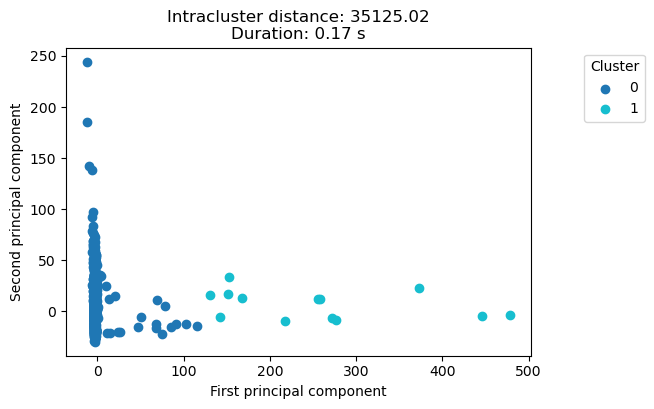

In [210]:
plot_result(gene_principal_components.values, clusters, end - start)

**Genetic algorithm:**

In [226]:
start = time.time()
clusters,_,_ = genetic_clustering(gene_principal_components.values, 2, 10, 0.15, 0.05, 200)
#print(clusters)
end = time.time()
print(f"Execution time: {end - start} seconds")

Best fitness: 2.803334255915451e-05
Best fitness: 2.8255293766186994e-05
Best fitness: 2.8445665437047756e-05
Best fitness: 2.846973529318264e-05
Best fitness: 2.874159574326048e-05
Best fitness: 3.470944998795481e-05
Best fitness: 3.739677888895612e-05
Best fitness: 3.7466735689055516e-05
Best fitness: 3.747591995825724e-05
Best fitness: 3.74778527028929e-05
Best fitness: 3.752975512225648e-05
Best fitness: 3.7530480792921767e-05
Execution time: 189.34681487083435 seconds


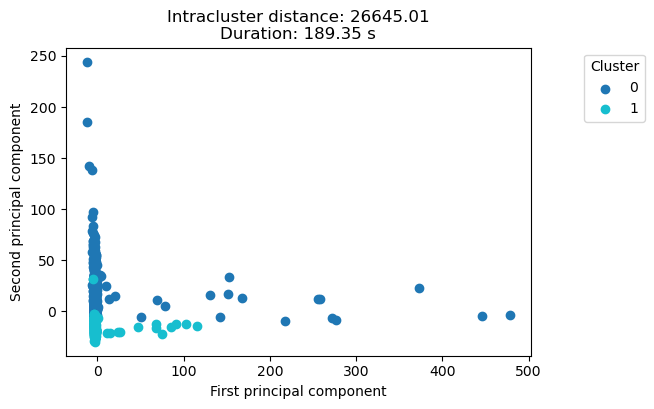

In [227]:
plot_result(gene_principal_components.values, clusters, end - start)

### Using half of the data set (n = 699)

**K-means:**

In [211]:
start = time.time()
clusters,_ = k_means(gene_principal_components.values[:700, :], 2)
#print(clusters)
end = time.time()
print(f"Execution time: {end - start} seconds")

Execution time: 0.09375166893005371 seconds


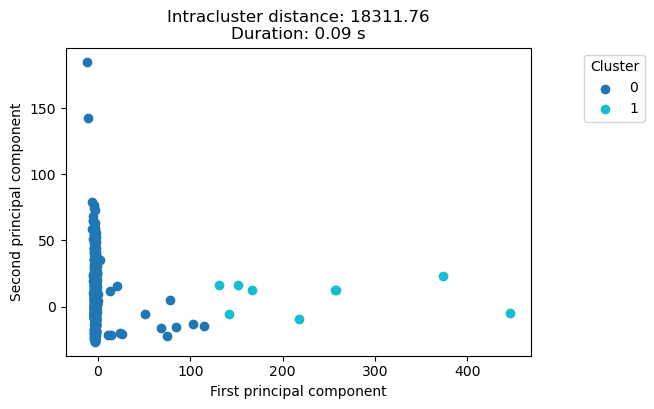

In [212]:
plot_result(gene_principal_components.values, clusters, end - start)

**Genetic algorithm:**

In [287]:
start = time.time()
clusters,_,_ = genetic_clustering(gene_principal_components.values[:700,:], 2, 10, 0.15, 0.05, 200)
#print(clusters):
end = time.time()
print(f"Execution time: {end - start} seconds")

Best fitness: 5.443390838735869e-05
Best fitness: 5.9595160432280424e-05
Best fitness: 6.365728523141697e-05
Best fitness: 6.61724958890818e-05
Best fitness: 6.66474879597522e-05
Best fitness: 6.69510613476773e-05
Best fitness: 6.701659466612073e-05
Best fitness: 6.704142064287424e-05
Best fitness: 6.706325113412252e-05
Best fitness: 6.70774774894967e-05
Best fitness: 6.712973344848157e-05
Execution time: 163.71512627601624 seconds


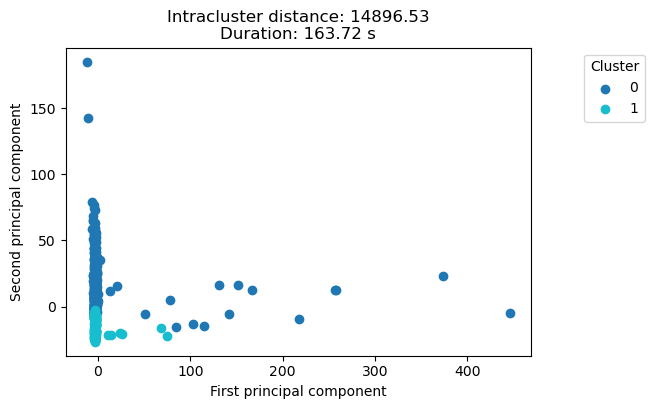

In [288]:
plot_result(gene_principal_components.values, clusters, end - start)

## Using variable size for brute force case

**Brute Force:**

**n = 8:**

In [293]:
# 2^10 = 1024
start = time.time()
clusters,_ = brute_force_clustering(gene_principal_components.values[:9, :], 2)
end = time.time()
print(f"Execution time: {end - start} seconds")

Minimum intracluster distance: 158.28395217770677
Minimum intracluster distance: 120.93428288353259
Minimum intracluster distance: 105.40221317427066
Minimum intracluster distance: 98.80197122101147
Minimum intracluster distance: 90.88878335289586
Minimum intracluster distance: 69.04211140244344
Execution time: 0.1250002384185791 seconds


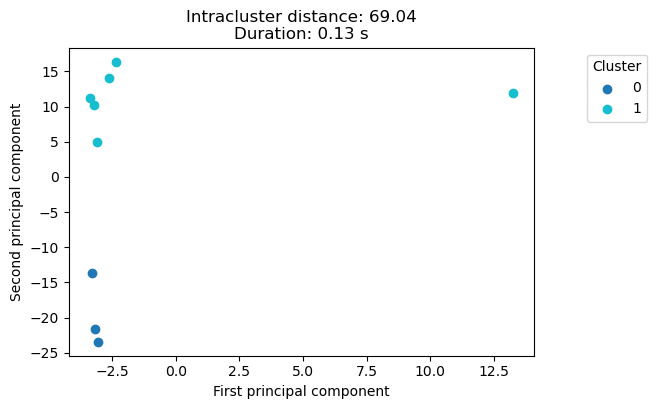

In [294]:
plot_result(gene_principal_components.values, clusters, end - start)

**n = 10:**

In [262]:
#2^10 = 1024
start = time.time()
clusters,_ = brute_force_clustering(gene_principal_components.values[:11, :], 2)
end = time.time()
print(f"Execution time: {end - start} seconds")

Minimum intracluster distance: 191.03670418519874
Minimum intracluster distance: 183.82740713575538
Minimum intracluster distance: 163.40502077079756
Minimum intracluster distance: 156.66145415704116
Minimum intracluster distance: 130.06610501821365
Minimum intracluster distance: 110.07366405592194
Minimum intracluster distance: 108.73874349241572
Minimum intracluster distance: 102.35300871808288
Minimum intracluster distance: 76.49572988040757
Minimum intracluster distance: 76.49572988040757
Execution time: 0.6249961853027344 seconds


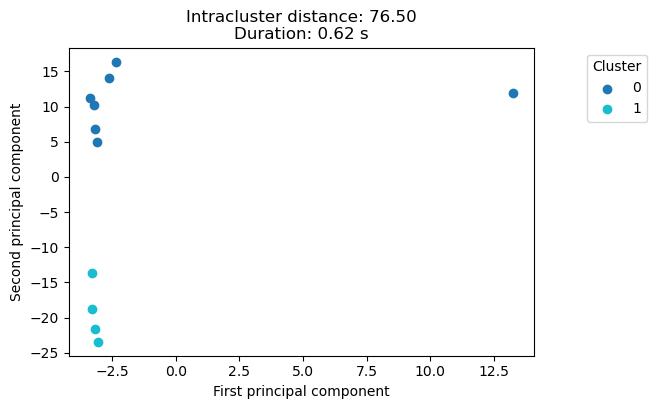

In [263]:
plot_result(gene_principal_components.values, clusters, end - start)

 **n = 12:**

In [236]:
#2^12 = 4096
start = time.time()
clusters,_ = brute_force_clustering(gene_principal_components.values[:13], 2)
end = time.time()
print(f"Execution time: {end - start} seconds")

Minimum intracluster distance: 262.0615255858646
Minimum intracluster distance: 217.27998433725764
Minimum intracluster distance: 212.3195432447211
Minimum intracluster distance: 206.0699048287206
Minimum intracluster distance: 179.17768524851917
Minimum intracluster distance: 162.93388732623683
Minimum intracluster distance: 158.86763282012296
Minimum intracluster distance: 149.97754414548132
Minimum intracluster distance: 129.6683300591096
Minimum intracluster distance: 129.66833005910956
Execution time: 2.062474250793457 seconds


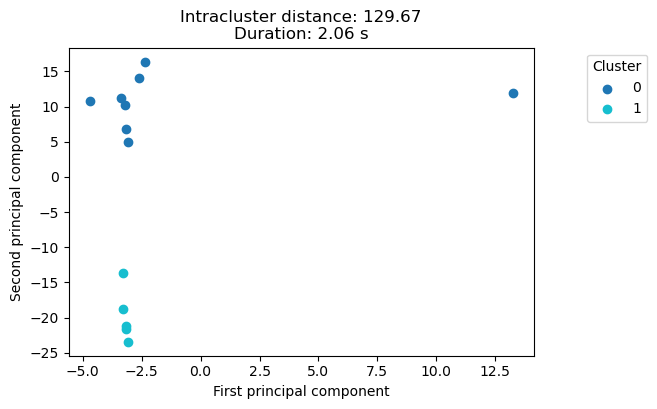

In [237]:
plot_result(gene_principal_components.values, clusters, end - start)

**n = 14**

In [269]:
# 2^16 = 16 384
start = time.time()
clusters,_ = brute_force_clustering(gene_principal_components.values[:15], 2)
end = time.time()
print(f"Execution time: {end - start} seconds")

Minimum intracluster distance: 276.27670745876543
Minimum intracluster distance: 266.80405392850395
Minimum intracluster distance: 231.464728979775
Minimum intracluster distance: 226.5908171773304
Minimum intracluster distance: 220.50023928968295
Minimum intracluster distance: 194.58050805749048
Minimum intracluster distance: 179.5487684076192
Minimum intracluster distance: 178.50934665575613
Minimum intracluster distance: 169.58636811538997
Minimum intracluster distance: 168.90851069883985
Minimum intracluster distance: 156.48306501971436
Minimum intracluster distance: 147.79013691365648
Minimum intracluster distance: 147.79013691365648
Execution time: 10.528354167938232 seconds


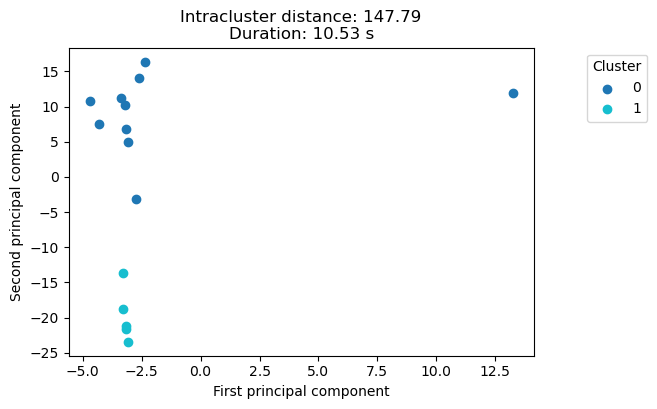

In [270]:
plot_result(gene_principal_components.values, clusters, end - start)

**n = 16:**

In [238]:
# 2^16 = 65536
start = time.time()
clusters,_ = brute_force_clustering(gene_principal_components.values[:17], 2)
end = time.time()
print(f"Execution time: {end - start} seconds")

Minimum intracluster distance: 328.9518735252607
Minimum intracluster distance: 302.6838499623334
Minimum intracluster distance: 299.92226678001657
Minimum intracluster distance: 284.3318899915037
Minimum intracluster distance: 273.7586648625796
Minimum intracluster distance: 248.72867391109844
Minimum intracluster distance: 242.73179344988557
Minimum intracluster distance: 214.3826168183008
Minimum intracluster distance: 199.6676215533172
Minimum intracluster distance: 193.9232873631284
Minimum intracluster distance: 192.55218793563813
Minimum intracluster distance: 176.9955108802431
Minimum intracluster distance: 167.7164284581968
Minimum intracluster distance: 167.7164284581968
Execution time: 33.68124341964722 seconds


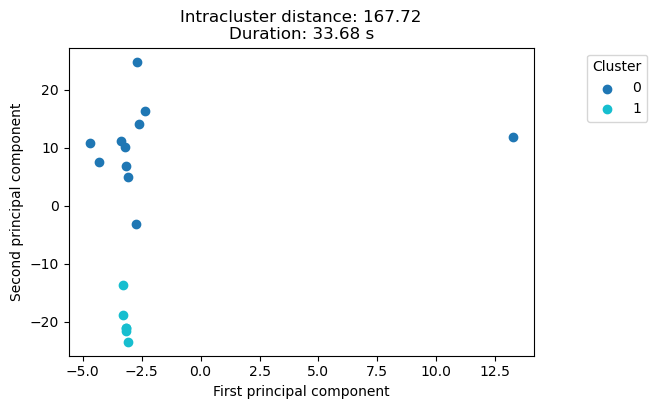

In [239]:
plot_result(gene_principal_components.values, clusters, end - start)

**n = 18:**

In [267]:
# 2^18 = 266 144
start = time.time()
clusters,_ = brute_force_clustering(gene_principal_components.values[:19], 2)
end = time.time()
print(f"Execution time: {end - start} seconds")

Minimum intracluster distance: 356.42006759198944
Minimum intracluster distance: 333.0544873488496
Minimum intracluster distance: 329.02570887117105
Minimum intracluster distance: 328.91045804221864
Minimum intracluster distance: 310.08481208888696
Minimum intracluster distance: 299.37079663088934
Minimum intracluster distance: 274.0331702380012
Minimum intracluster distance: 268.2347863113018
Minimum intracluster distance: 240.2066634710266
Minimum intracluster distance: 225.80932010220525
Minimum intracluster distance: 223.06062934830504
Minimum intracluster distance: 220.82517364579672
Minimum intracluster distance: 219.86544114474486
Minimum intracluster distance: 211.44638299396712
Minimum intracluster distance: 203.04801221928676
Minimum intracluster distance: 194.08899329679568
Execution time: 177.31167936325073 seconds


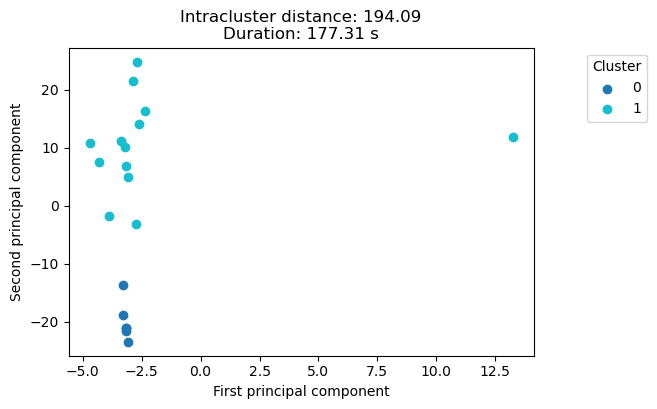

In [268]:
plot_result(gene_principal_components.values, clusters, end - start)

**n = 20:**

In [264]:
# 2^20 = 2 097 152
start = time.time()
clusters,_ = brute_force_clustering(gene_principal_components.values[:21], 2)
end = time.time()
print(f"Execution time: {end - start} seconds")

Minimum intracluster distance: 416.51143337933496
Minimum intracluster distance: 408.22375833642866
Minimum intracluster distance: 366.88086749327726
Minimum intracluster distance: 361.1819399797522
Minimum intracluster distance: 352.7680730723294
Minimum intracluster distance: 326.00500735525276
Minimum intracluster distance: 320.6872429144386
Minimum intracluster distance: 292.92847164336416
Minimum intracluster distance: 278.58613197748775
Minimum intracluster distance: 277.9828777845194
Minimum intracluster distance: 276.3118991902821
Minimum intracluster distance: 275.68920103351536
Minimum intracluster distance: 264.26193028013853
Minimum intracluster distance: 256.697482824424
Minimum intracluster distance: 248.4130001337857
Minimum intracluster distance: 248.4130001337857
Execution time: 713.3074707984924 seconds


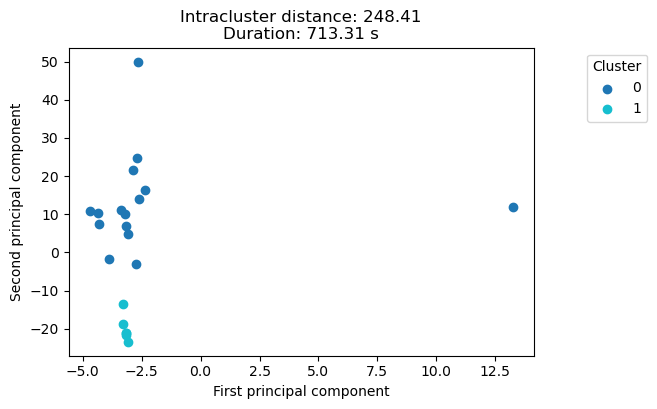

In [265]:
plot_result(gene_principal_components.values, clusters, end - start)

**n = 21:**

In [291]:
# 2^20 = 1 048 576
start = time.time()
clusters,_ = brute_force_clustering(gene_principal_components.values[:22], 2)
end = time.time()
print(f"Execution time: {end - start} seconds")

Minimum intracluster distance: 427.8788694734035
Minimum intracluster distance: 416.51143337933496
Minimum intracluster distance: 375.8223688340749
Minimum intracluster distance: 367.42142006915384
Minimum intracluster distance: 366.87807422744294
Minimum intracluster distance: 341.0347662679707
Minimum intracluster distance: 335.7197719530672
Minimum intracluster distance: 308.6496109209603
Minimum intracluster distance: 294.9287593912371
Minimum intracluster distance: 293.51697517328654
Minimum intracluster distance: 288.2712910603381
Minimum intracluster distance: 288.2238593793894
Minimum intracluster distance: 277.50890689403747
Minimum intracluster distance: 273.7193014618121
Minimum intracluster distance: 269.2445198374527
Minimum intracluster distance: 265.060226351112
Minimum intracluster distance: 265.06022635111196
Execution time: 1381.3564803600311 seconds


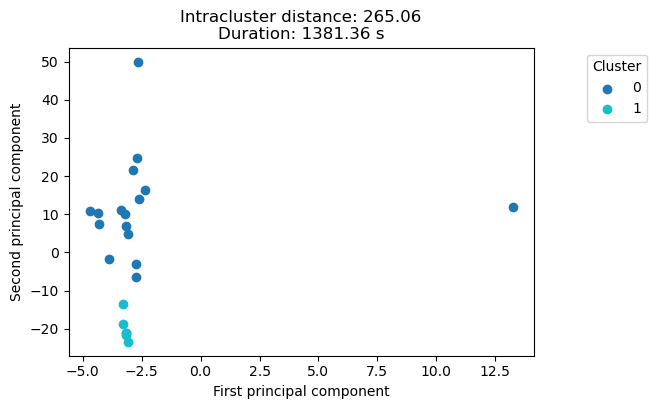

In [292]:
plot_result(gene_principal_components.values, clusters, end - start)

**n = 22:**

In [244]:
# 2^22 = 4 194 304
start = time.time()
clusters,_ = brute_force_clustering(gene_principal_components.values[:23,:], 2)
end = time.time()
print(f"Execution time: {end - start} seconds")

Minimum intracluster distance: 543.868257765247
Minimum intracluster distance: 427.8788694734035
Minimum intracluster distance: 418.2218212881445
Minimum intracluster distance: 417.3423498266706
Minimum intracluster distance: 415.6602413511231
Minimum intracluster distance: 415.3536162485171
Minimum intracluster distance: 401.3757846990923
Minimum intracluster distance: 397.59119824262007
Minimum intracluster distance: 392.79148318262315
Minimum intracluster distance: 388.4632938613877
Minimum intracluster distance: 388.4632938613876
Execution time: 2763.4661886692047 seconds


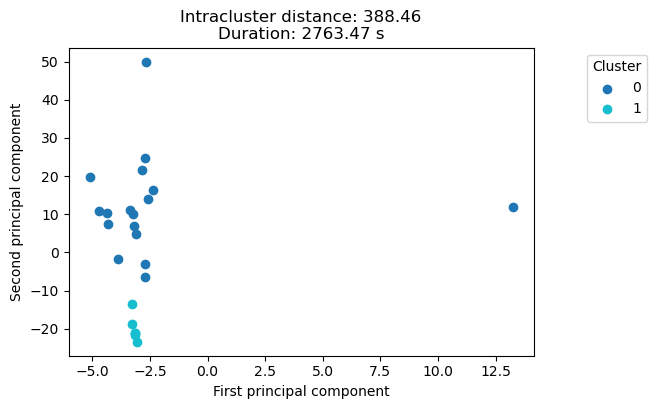

In [245]:
plot_result(gene_principal_components.values, clusters, end - start)

## k = 4

### Using the full data set (n = 1398)

**K-means:**

In [203]:
start = time.time()
clusters,_ = k_means(gene_principal_components.values, 4)
#print(clusters)
end = time.time()
print(f"Execution time: {end - start} seconds")

Execution time: 0.7343778610229492 seconds


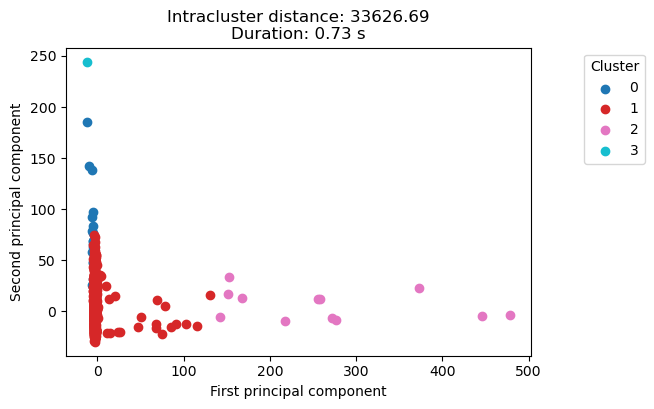

In [204]:
plot_result(gene_principal_components.values, clusters, end - start)

**Genetic algorithm:**

In [207]:
start = time.time()
clusters,_,_ = genetic_clustering(gene_principal_components.values, 4, 10, 0.15, 0.05, 200)
#print(clusters)
end = time.time()
print(f"Execution time: {end - start} seconds")

Best fitness: 2.968310180545423e-05
Best fitness: 3.400055012391497e-05
Best fitness: 4.054255055998705e-05
Best fitness: 4.2514054988360524e-05
Best fitness: 4.324632573914715e-05
Best fitness: 4.425476765009171e-05
Best fitness: 4.7099211226285314e-05
Best fitness: 4.713496003333761e-05
Best fitness: 4.7310428460479545e-05
Best fitness: 4.757324502243339e-05
Execution time: 257.41792368888855 seconds


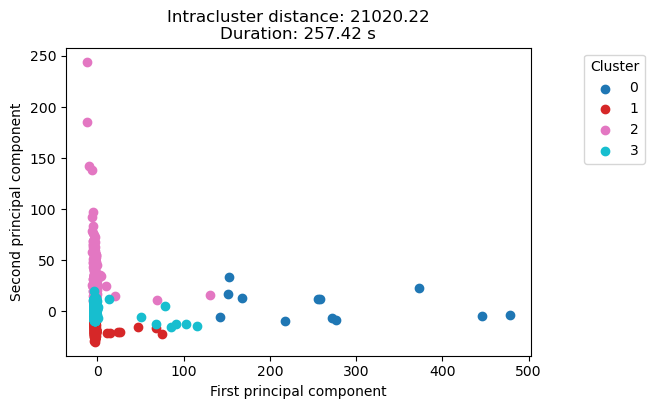

In [208]:
plot_result(gene_principal_components.values, clusters, end - start)

### Using half of the data set (n = 699)

**K-means:**

In [215]:
start = time.time()
clusters,_ = k_means(gene_principal_components.values[:700, :], 4)
#print(clusters)
end = time.time()
print(f"Execution time: {end - start} seconds")

Execution time: 0.15625452995300293 seconds


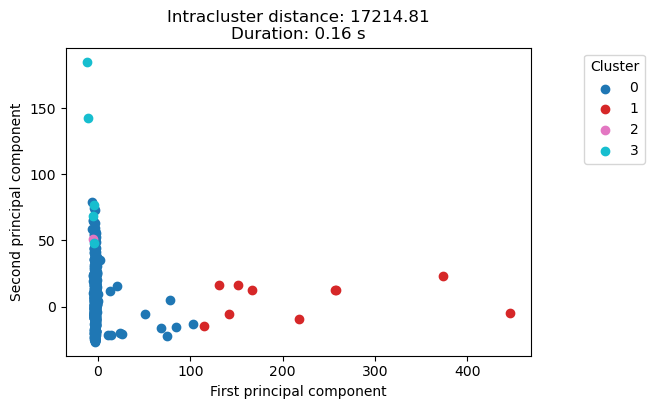

In [216]:
plot_result(gene_principal_components.values, clusters, end - start)

**Genetic algorithm:**

In [272]:
start = time.time()
clusters,_,_ = genetic_clustering(gene_principal_components.values[:700, :], 4, 10, 0.15, 0.05, 200)
#print(clusters)
end = time.time()
print(f"Execution time: {end - start} seconds")

Best fitness: 5.6439281082246874e-05
Best fitness: 6.254917240617217e-05
Best fitness: 6.494680321031752e-05
Best fitness: 6.615124593196174e-05
Best fitness: 7.375324838686127e-05
Best fitness: 7.518575976332794e-05
Best fitness: 7.761392701677347e-05
Best fitness: 7.775105890995711e-05
Best fitness: 8.018618154686608e-05
Best fitness: 8.192965635342873e-05
Best fitness: 8.448776598736066e-05
Best fitness: 8.607449511143314e-05
Best fitness: 8.612380840577775e-05
Best fitness: 8.67984707460387e-05
Best fitness: 8.686943018593056e-05
Best fitness: 8.71023441244151e-05
Execution time: 157.2251579761505 seconds


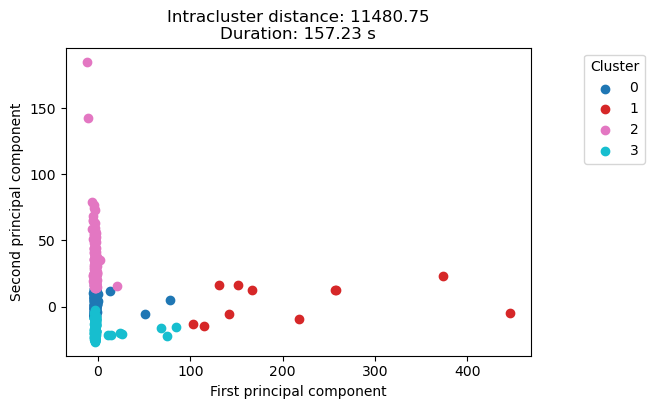

In [273]:
plot_result(gene_principal_components.values, clusters, end - start)

## K = 6

### Using the full data set (n = 1398)

**K-means:**

In [217]:
start = time.time()
clusters,_ = k_means(gene_principal_components.values, 6)
#print(clusters)
end = time.time()
print(f"Execution time: {end - start} seconds")

Execution time: 8.187938213348389 seconds


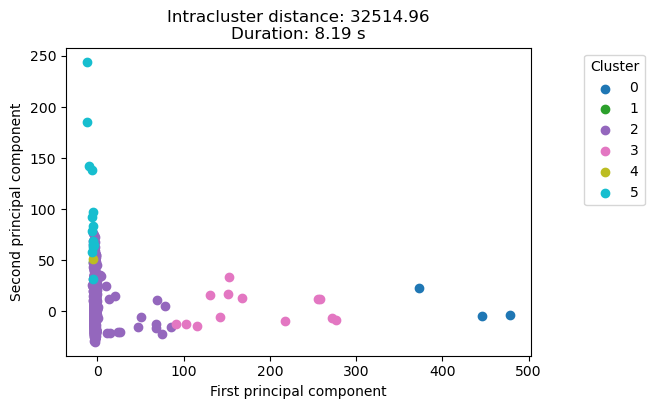

In [218]:
plot_result(gene_principal_components.values, clusters, end - start)

**Genetic algorithm:**

In [274]:
start = time.time()
clusters,_,_ = genetic_clustering(gene_principal_components.values, 6, 10, 0.15, 0.5, 200)
print(clusters)
end = time.time()
print(f"Execution time: {end - start} seconds")

Best fitness: 2.9751742784811266e-05
Best fitness: 3.6470649778043506e-05
Best fitness: 4.293899888400854e-05
Best fitness: 4.4362075287850695e-05
Best fitness: 4.872735771292707e-05
Best fitness: 4.907944740583466e-05
Best fitness: 5.0642082737374536e-05
Best fitness: 5.070073284554278e-05
Best fitness: 5.2348171410764e-05
[[26, 119, 192, 200, 208, 397, 399, 441, 449, 475, 537, 663, 717, 741, 743, 749, 752, 765, 781, 821, 829, 855, 879, 969, 983, 1017, 1018, 1075, 1092, 1099, 1297], [2, 7, 10, 13, 17, 21, 29, 35, 36, 39, 41, 46, 47, 48, 49, 50, 52, 53, 54, 56, 59, 60, 70, 75, 76, 78, 79, 81, 82, 85, 88, 90, 91, 94, 97, 100, 102, 104, 106, 111, 120, 131, 134, 142, 147, 148, 150, 155, 157, 162, 166, 174, 176, 181, 190, 193, 194, 195, 198, 199, 210, 216, 220, 222, 223, 226, 237, 239, 240, 241, 244, 250, 251, 256, 263, 264, 269, 271, 272, 274, 277, 278, 282, 287, 289, 291, 292, 294, 296, 298, 300, 308, 309, 316, 317, 321, 331, 338, 356, 359, 372, 379, 391, 401, 403, 406, 408, 409, 410, 41

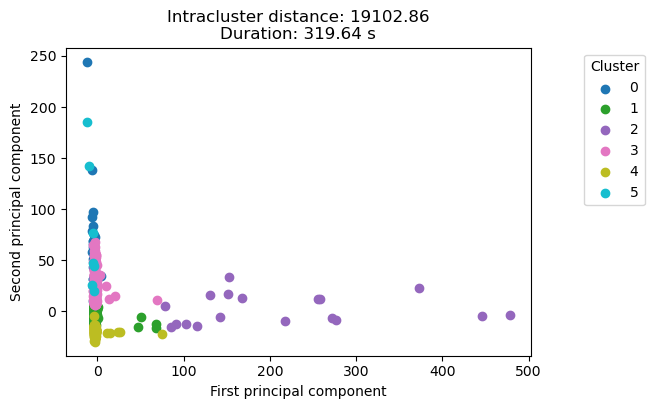

In [275]:
plot_result(gene_principal_components.values, clusters, end - start)

### Using half of the data set (n = 699)

**K-means:**

In [278]:
start = time.time()
clusters,_ = k_means(gene_principal_components.values[:700, :], 6)
#print(clusters)
end = time.time()
print(f"Execution time: {end - start} seconds")

Execution time: 0.6453135013580322 seconds


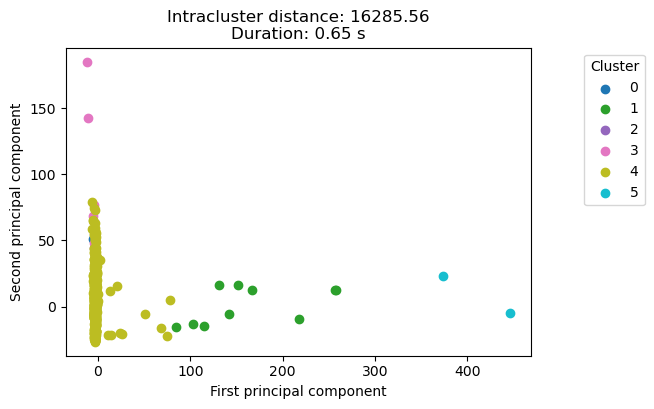

In [279]:
plot_result(gene_principal_components.values, clusters, end - start)

**Genetic algorithm:**

In [281]:
start = time.time()
clusters,_,_ = genetic_clustering(gene_principal_components.values[:700, :], 6, 10, 0.15, 0.5, 200)
end = time.time()
print(f"Execution time: {end - start} seconds")

Best fitness: 7.117262220022654e-05
Best fitness: 7.183066579853166e-05
Best fitness: 7.7426590255349e-05
Best fitness: 8.084008511634795e-05
Best fitness: 9.003922933445905e-05
Best fitness: 9.462112947001431e-05
Best fitness: 9.601026669449504e-05
Best fitness: 9.781554191100215e-05
Execution time: 170.46654295921326 seconds


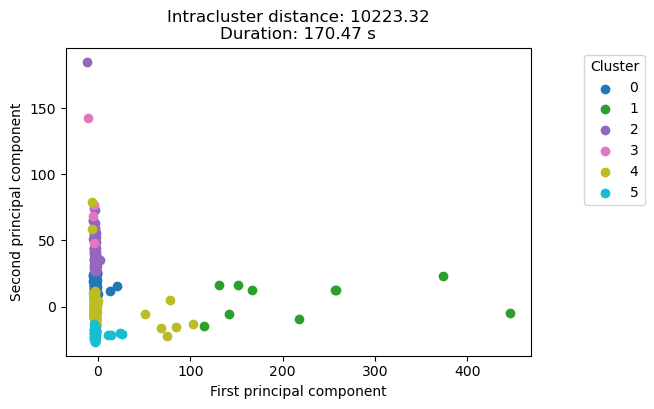

In [282]:
plot_result(gene_principal_components.values, clusters, end - start)

## k = 8

### Using the full data set (n = 1398)

**K-means:**

In [222]:
start = time.time()
clusters,_ = k_means(gene_principal_components.values, 8)
#print(clusters)
end = time.time()
print(f"Execution time: {end - start} seconds")

Execution time: 12.843752145767212 seconds


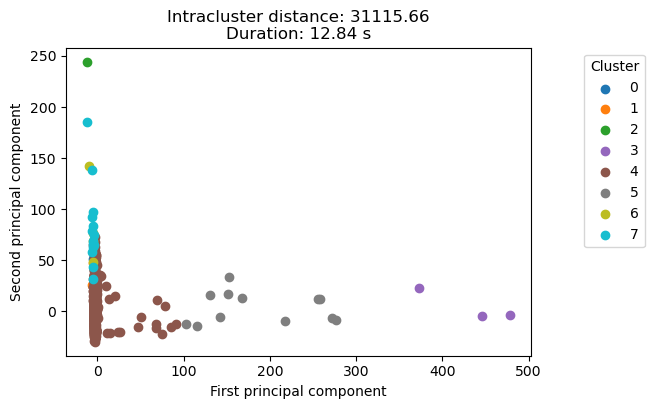

In [223]:
plot_result(gene_principal_components.values, clusters, end - start)

**Genetic algorithm:**

In [283]:
start = time.time()
clusters,_,_ = genetic_clustering(gene_principal_components.values, 8, 10, 0.15, 0.5, 200)
print(clusters)
end = time.time()
print(f"Execution time: {end - start} seconds")

Best fitness: 4.0353917615321175e-05
Best fitness: 4.1735317490522506e-05
Best fitness: 4.369610463498005e-05
Best fitness: 4.379016301542676e-05
Best fitness: 4.901487240194028e-05
Best fitness: 5.1073193169759014e-05
Best fitness: 5.258449773508379e-05
Best fitness: 5.3107543571515414e-05
Best fitness: 5.3494064706950904e-05
Best fitness: 5.561215755711832e-05
[[207, 233, 267, 473, 492, 862, 1040, 1121], [26], [208, 275, 586, 671, 981, 1391], [1, 4, 6, 15, 18, 19, 23, 27, 30, 32, 34, 43, 44, 55, 57, 67, 69, 72, 83, 86, 87, 93, 96, 99, 105, 112, 122, 124, 125, 126, 137, 140, 141, 143, 144, 151, 152, 156, 159, 161, 163, 164, 167, 168, 170, 173, 177, 178, 179, 180, 185, 187, 192, 202, 205, 209, 218, 221, 225, 227, 242, 243, 257, 259, 265, 270, 283, 284, 286, 288, 295, 299, 302, 306, 310, 311, 313, 327, 329, 333, 334, 343, 351, 357, 360, 365, 377, 380, 381, 383, 388, 393, 396, 398, 400, 407, 411, 412, 417, 423, 424, 426, 429, 430, 439, 446, 450, 451, 458, 472, 477, 480, 481, 483, 496, 49

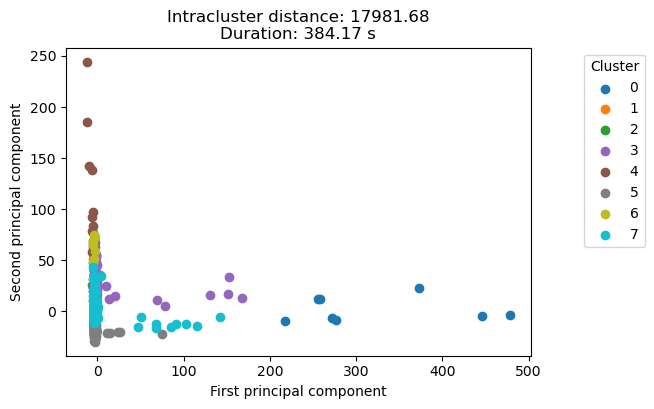

In [284]:
plot_result(gene_principal_components.values, clusters, end - start)

### Using half of the data set (n = 699)

**k-means:**

In [224]:
start = time.time()
clusters,_ = k_means(gene_principal_components.values[:700], 8)
#print(clusters)
end = time.time()
print(f"Execution time: {end - start} seconds")

Execution time: 8.86242151260376 seconds


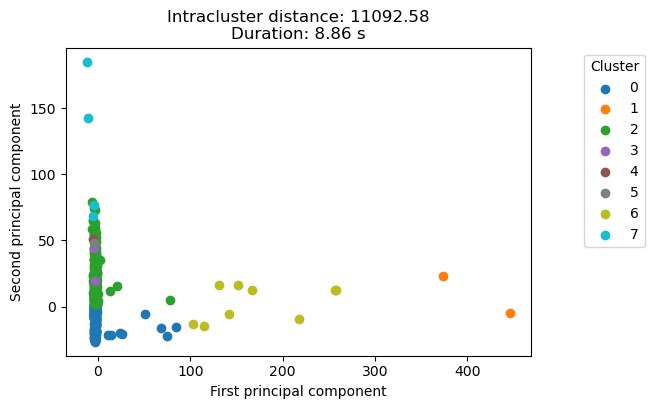

In [225]:
plot_result(gene_principal_components.values, clusters, end - start)

**Genetic algorithm:**

In [285]:
start = time.time()
clusters,_,_ = genetic_clustering(gene_principal_components.values[:700, :], 8, 10, 0.15, 0.5, 200)
print(clusters)
end = time.time()
print(f"Execution time: {end - start} seconds")

Best fitness: 6.574279334914577e-05
Best fitness: 8.260474385487083e-05
Best fitness: 8.458381610351132e-05
Best fitness: 8.932931930387608e-05
Best fitness: 9.225364055445277e-05
Best fitness: 9.643574341459659e-05
Best fitness: 9.71692092130424e-05
Best fitness: 9.970520177343927e-05
Best fitness: 9.987675567377496e-05
Best fitness: 0.00010140381225826444
Best fitness: 0.00010389353283370929
[[112, 204, 205, 206, 207, 232, 233, 324, 430, 462, 491, 492, 632], [267, 473], [2, 5, 10, 12, 13, 14, 17, 20, 21, 29, 35, 36, 39, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 59, 60, 62, 64, 73, 74, 75, 78, 79, 81, 85, 88, 90, 91, 92, 94, 95, 97, 101, 102, 104, 106, 111, 117, 120, 131, 133, 134, 138, 139, 142, 147, 148, 150, 155, 162, 166, 174, 181, 190, 193, 194, 195, 199, 200, 212, 216, 217, 219, 222, 223, 236, 237, 239, 240, 241, 244, 245, 247, 249, 250, 251, 253, 254, 256, 258, 262, 266, 269, 271, 272, 274, 277, 278, 280, 282, 287, 289, 291, 292, 296, 298, 300, 301, 308, 309, 314, 316, 317, 318, 

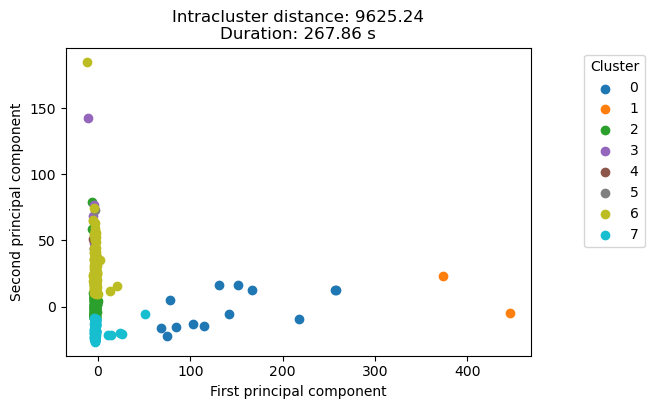

In [286]:
plot_result(gene_principal_components.values, clusters, end - start)

# Performance tests summary

In [350]:
# Load data
perf_tests = pd.read_csv("performance_tests.csv", sep = ";")
perf_tests

,Algorithm,k,N,duration,intra_distance
0,k-means,2,1398,0.17,35125.00
1,genetic,2,1398,189.35,26645.00
2,k-means,2,699,0.90,18311.76
3,genetic,2,699,163.72,14896.53
4,brute_force,2,8,0.13,69.04
5,brute_force,2,10,0.62,76.50
6,brute_force,2,12,2.06,129.67
7,brute_force,2,14,10.53,147.79
8,brute_force,2,16,33.68,167.72
9,brute_force,2,18,177.31,194.09


In [351]:
# Filter data for brute_force and k=2
brute_force = perf_tests[(perf_tests['Algorithm'] == 'brute_force') & (perf_tests['k'] == 2)]

In [352]:
brute_force

,Algorithm,k,N,duration,intra_distance
4,brute_force,2,8,0.13,69.04
5,brute_force,2,10,0.62,76.50
6,brute_force,2,12,2.06,129.67
7,brute_force,2,14,10.53,147.79
8,brute_force,2,16,33.68,167.72
9,brute_force,2,18,177.31,194.09
10,brute_force,2,20,713.31,248.41
11,brute_force,2,21,1381.36,265.06
12,brute_force,2,22,2763.47,388.46


## Performance of brute force algorithm for k = 2

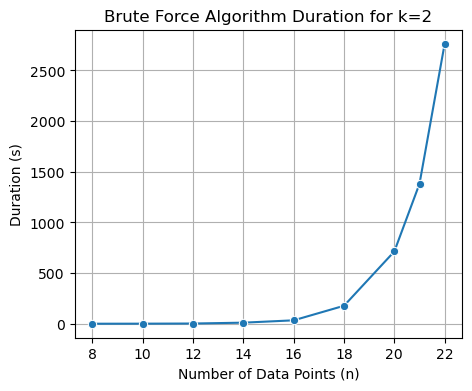

In [ ]:
import seaborn as sns

plt.figure(figsize=(5, 4))
sns.lineplot(data=brute_force, x='N', y='duration', marker='o')
plt.title('Brute Force Algorithm Duration for k=2')
plt.xlabel('Number of Data Points (n)')
plt.ylabel('Duration (s)')
plt.grid(True)
plt.show()

## Performance of the K-means and genetic algorithms when increasing the value of K

In [355]:
# Create a DataFrame that excludes the rows in brute_force
performance_df = perf_tests[~perf_tests.isin(brute_force).all(axis=1)]

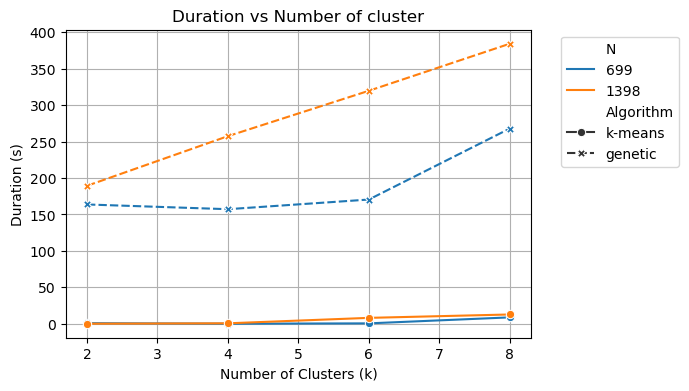

In [364]:
# Create the plot duration vs. number of clusters 
plt.figure(figsize=(6, 4))
sns.lineplot(data=performance_df, x='k', y='duration', style='Algorithm', hue='N', markers=True, dashes=True, palette='tab10')
plt.title('Duration vs Number of cluster')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Duration (s)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

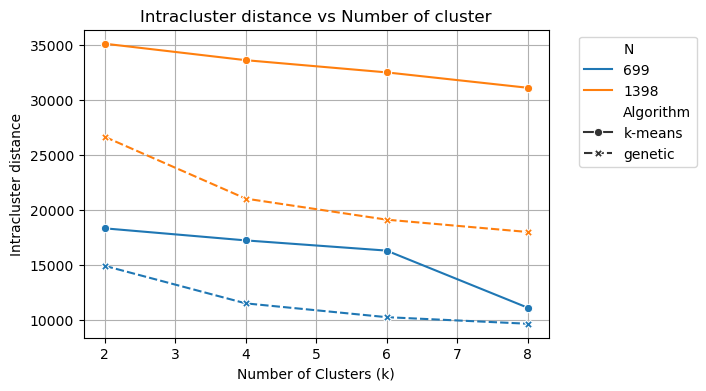

In [363]:
# Create the plot intercluster distance vs. number of clusters 
plt.figure(figsize=(6, 4))
sns.lineplot(data=performance_df, x='k', y='intra_distance', style='Algorithm', hue='N', markers=True, dashes=True, palette='tab10')
plt.title('Intracluster distance vs Number of cluster')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Intracluster distance')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()